In [1]:
import os

def find_line_starts_with(lines, pref):
    for l in lines:
        if l.startswith(pref):
            return l
    return None

def parse_field(lines, key):
    line = find_line_starts_with(lines, key)
    return line[len(key) + 1:].strip()

def extract_config_results(root):
    runs = os.listdir(root)
    result = dict()
    for run in runs:
        try:
            with open(os.path.join(root, run, 'log'), 'r') as log:
                data = log.readlines()
                if find_line_starts_with(data, 'timeout') is not None:
                    result[run] = {'status': 'timeout'}
                    continue
                memory = int(parse_field(data, 'memory'))
                time = float(parse_field(data, 'time'))
                expansions = int(parse_field(data, 'expansions'))
                distance = float(parse_field(data, 'distance'))
                result[run] = {
                    'status': 'ok',
                    'memory': memory,
                    'time': time,
                    'expansions': expansions,
                    'distance': distance
                }
        except Exception as e:
            print(f'error on {os.path.join(root, run, "log")}: {e}')
    return result

def extract_algo_results(root):
    result = dict()
    configs = os.listdir(root)
    for config in configs:
        result[config] = extract_config_results(os.path.join(root, config))
    return result

def extract_map_results(root):
    result = dict()
    algos = os.listdir(root)
    for algo in algos:
        result[algo] = extract_algo_results(os.path.join(root, algo))
    return result

def extract_results(root):
    maps = os.listdir(root)
    result = dict()
    for map_name in maps:
        result[map_name] = extract_map_results(os.path.join(root, map_name))
    return result

In [2]:
results = extract_results('./bench-results')

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (24,8)

In [4]:
def calc_success_data(cfg):
    runs = 0
    oks = 0
    timeouts = 0
    for run, data in cfg.items():
        runs += 1
        if data['status'] == 'timeout':
            timeouts += 1
        else:
            oks += 1
    return runs, oks, timeouts

def plot_success_rates(name2config):
    plt.xlabel('config')
    plt.ylabel('success rate, %')
    order = sorted(name2config.keys())
    for name in order:
        runs, oks, timeouts = calc_success_data(name2config[name])
        success_ratio = oks / runs
        plt.bar(name, success_ratio * 100.0)

In [5]:
def calc_average_metrics(cfg):
    oks = 0
    expansions = 0
    memory = 0
    time = 0
    distance = 0
    for run, data in cfg.items():
        if data['status'] == 'ok':
            oks += 1
            expansions += data['expansions']
            memory += data['memory']
            time += data['time']
            distance += data['distance']
    return {'time': time / oks, 'memory': memory / oks, 'expansions': expansions / oks, 'distance': distance / oks}

def plot_metric(name2config, metric):
    plt.xlabel('config')
    plt.ylabel(metric)
    order = sorted(name2config.keys())
    for name in order:
        data = calc_average_metrics(name2config[name])
        plt.bar(name, data[metric])

In [6]:
def show_plots(map_results):
    plt.title('A*, R* success rates')
    plot_success_rates(map_results['astar'])
    plot_success_rates(map_results['rstar'])
    plt.show()
    plt.title('A*, R* average expansions')
    plot_metric(map_results['astar'], 'expansions')
    plot_metric(map_results['rstar'], 'expansions')
    plt.show()
    plt.title('A*, R* average time')
    plot_metric(map_results['astar'], 'time')
    plot_metric(map_results['rstar'], 'time')
    plt.show()

![broken steppes](./dataset/starcraft/BrokenSteppes.png)

Success Rate -- в какой доле запусков алгоритм нашел путь, ограничение: таймаут 5 секунд.

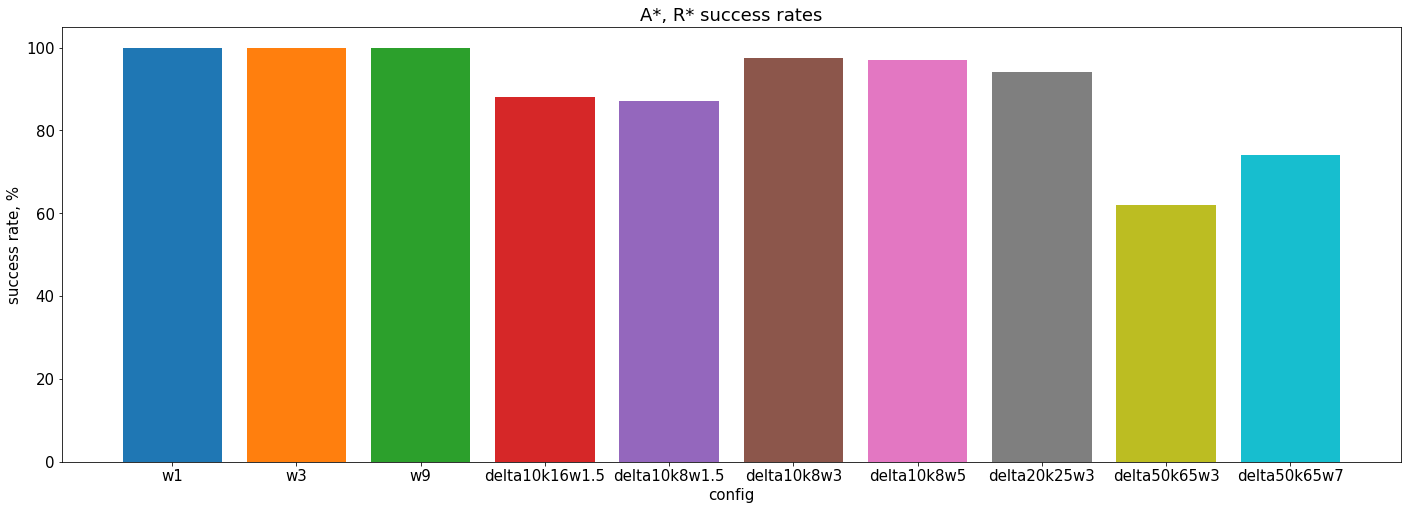

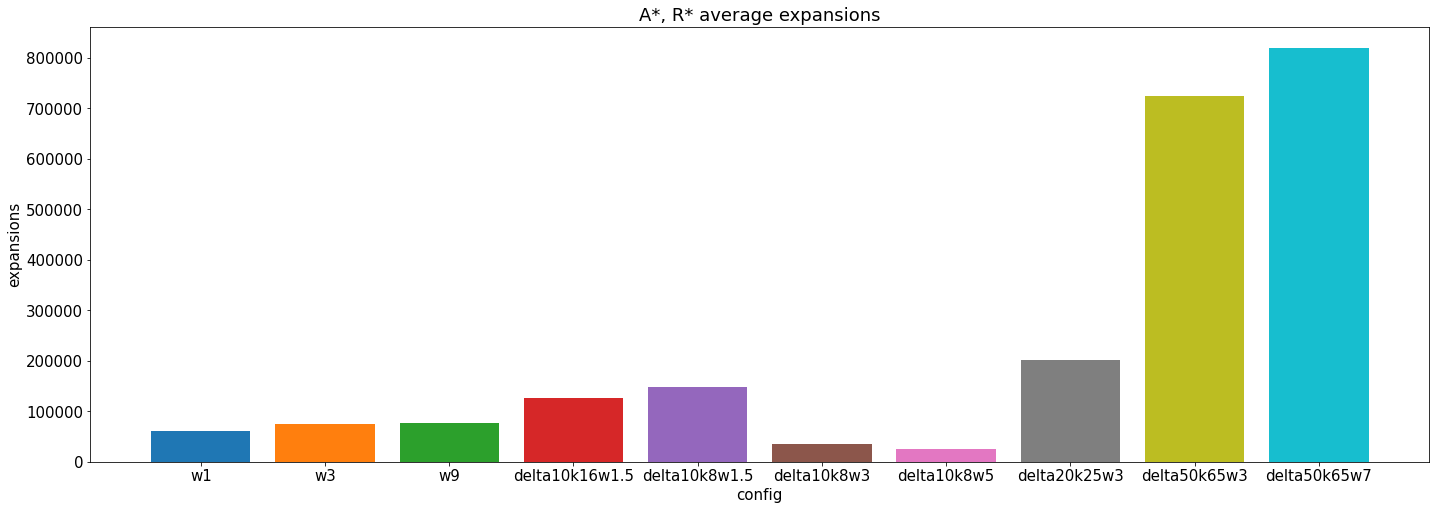

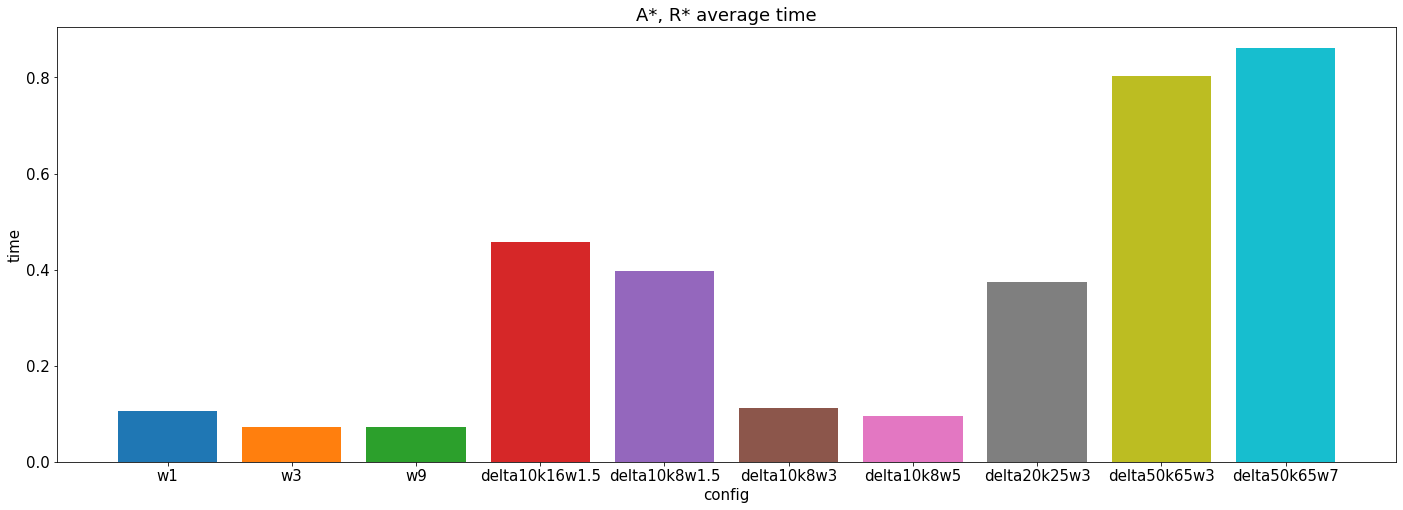

In [7]:
show_plots(results['sc-broken-steppes'])

![broken steppes](./dataset/starcraft/Legacy.png)

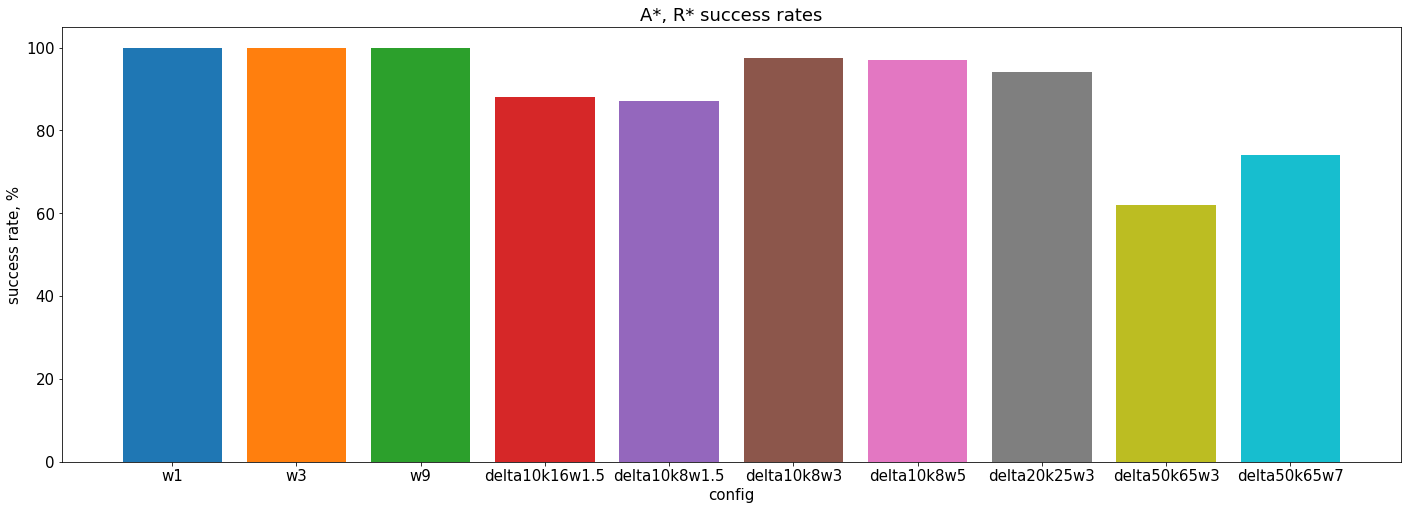

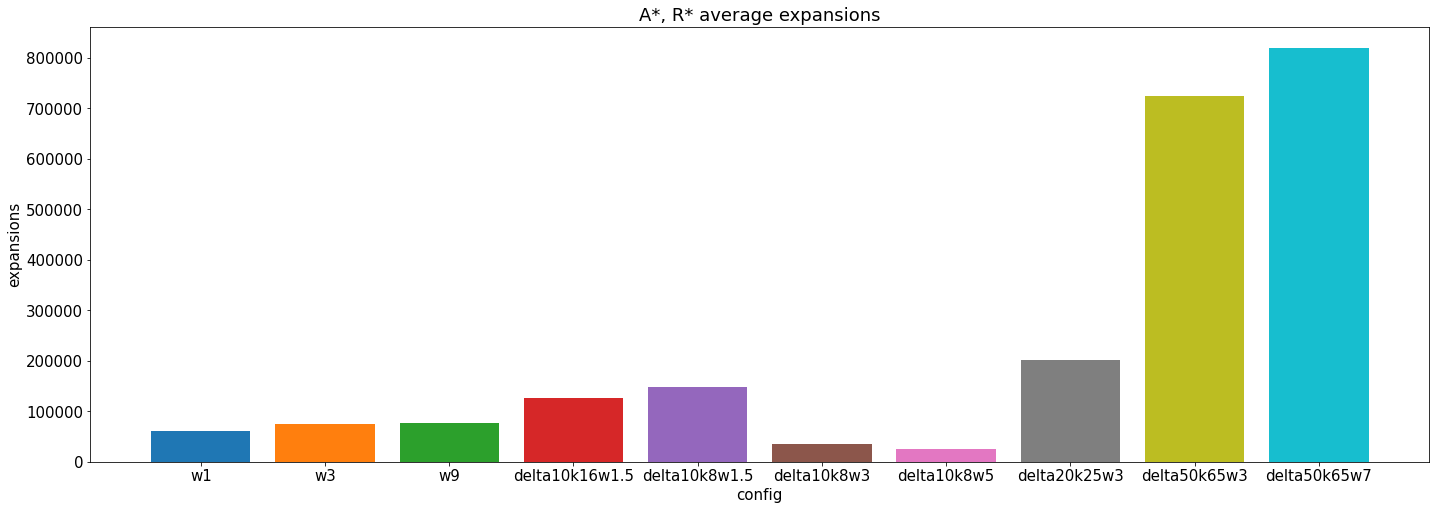

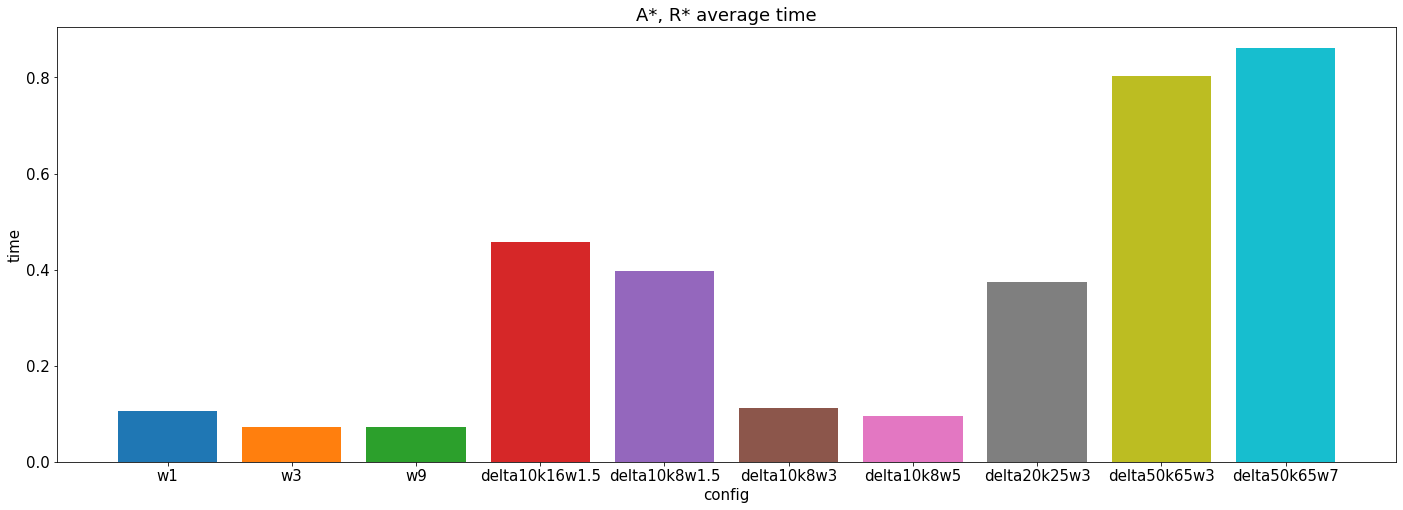

In [8]:
show_plots(results['sc-broken-steppes'])

![sc-wheel-of-war](./dataset/starcraft/WheelofWar.png)

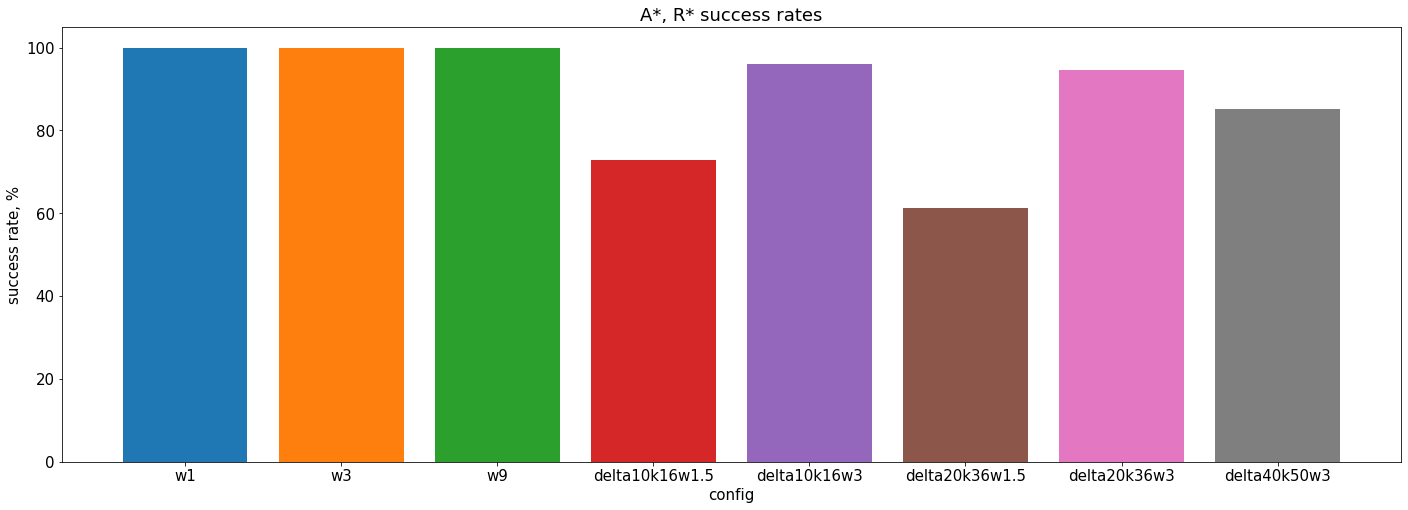

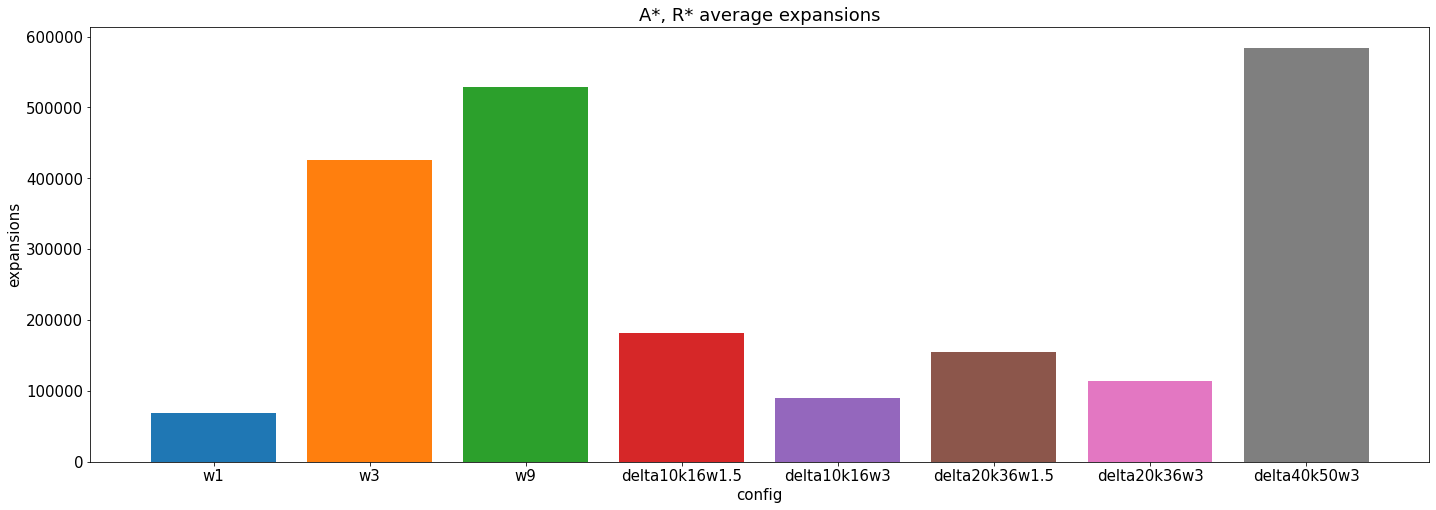

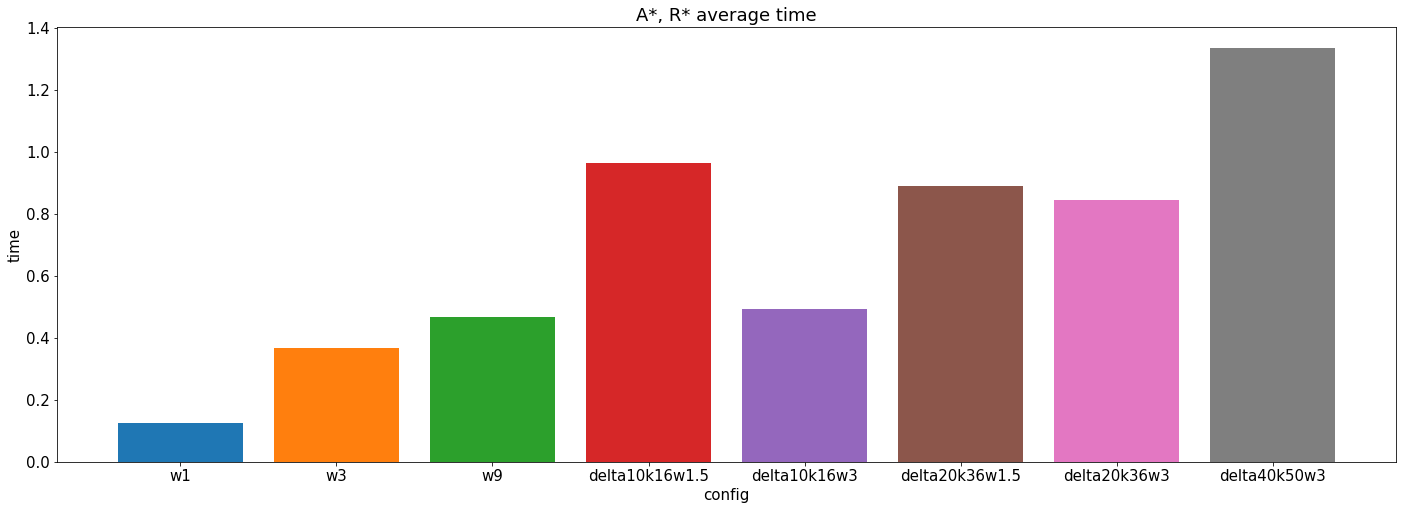

In [9]:
show_plots(results['sc-wheel-of-war'])

![cities-milan](./dataset/cities/Milan_1_1024.png)

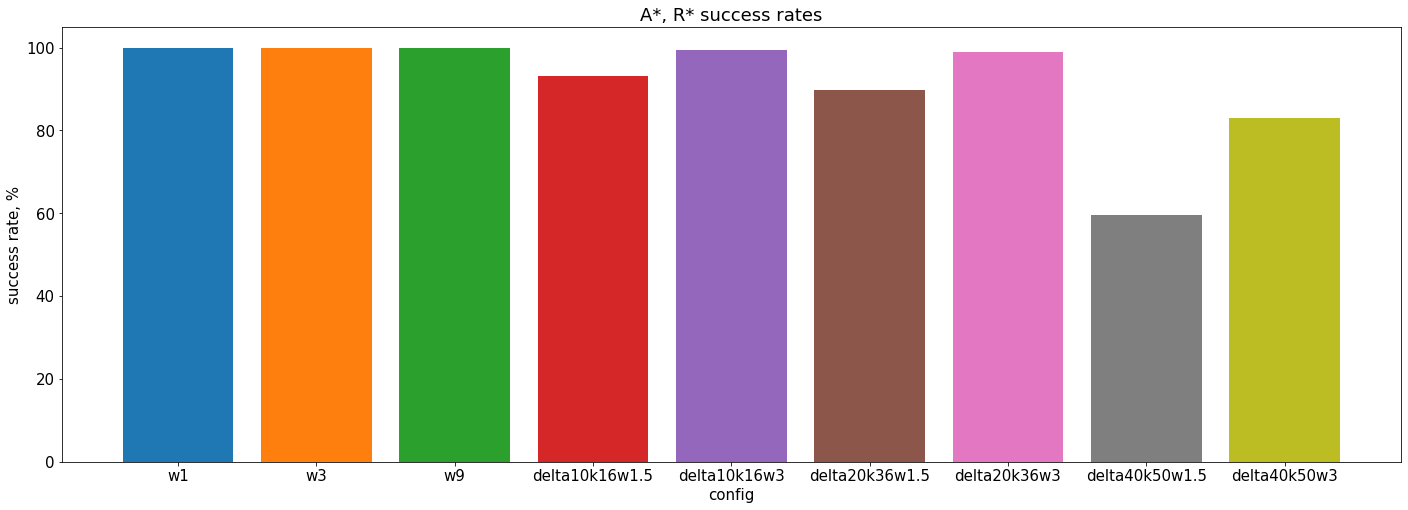

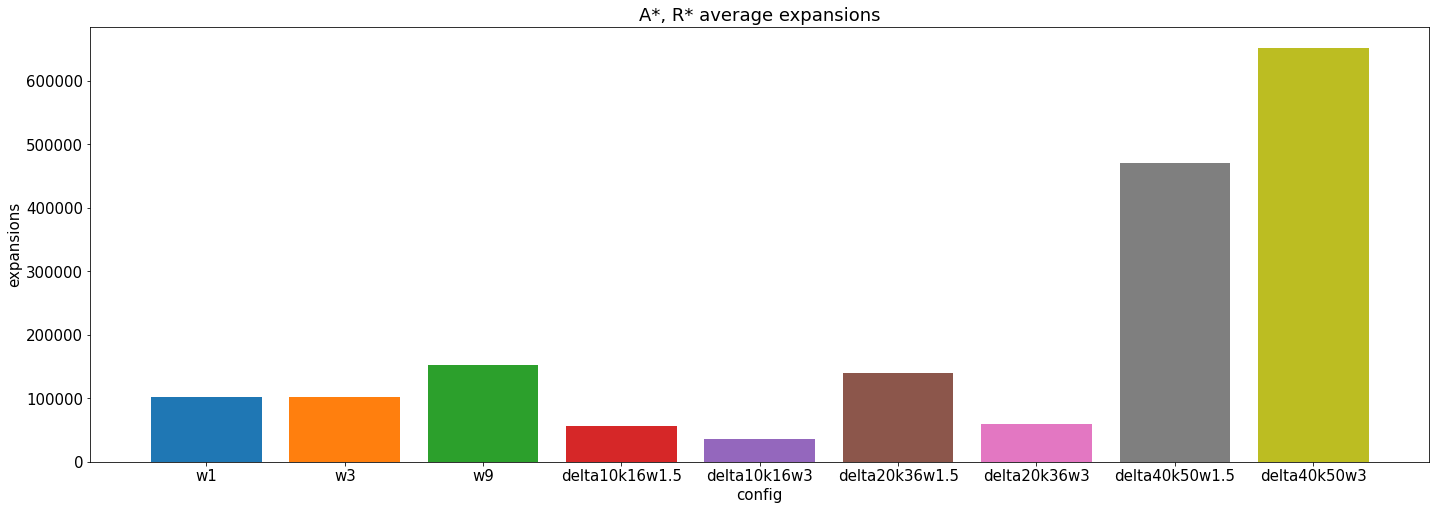

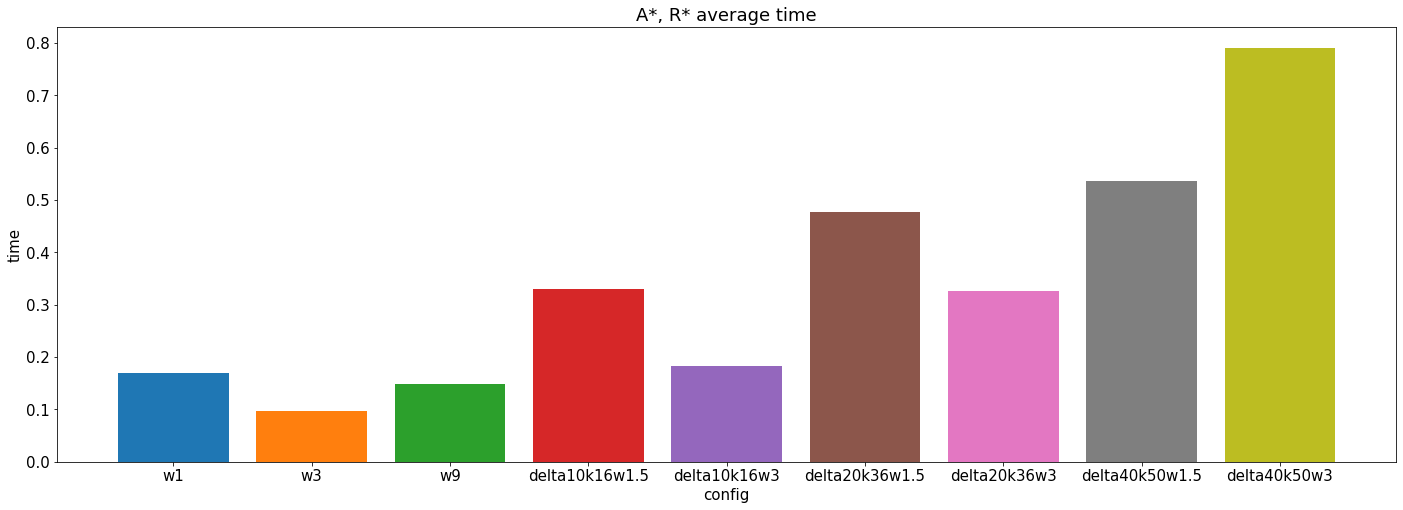

In [10]:
show_plots(results['cities-milan'])

![cities-newyork](./dataset/cities/NewYork_1_1024.png)

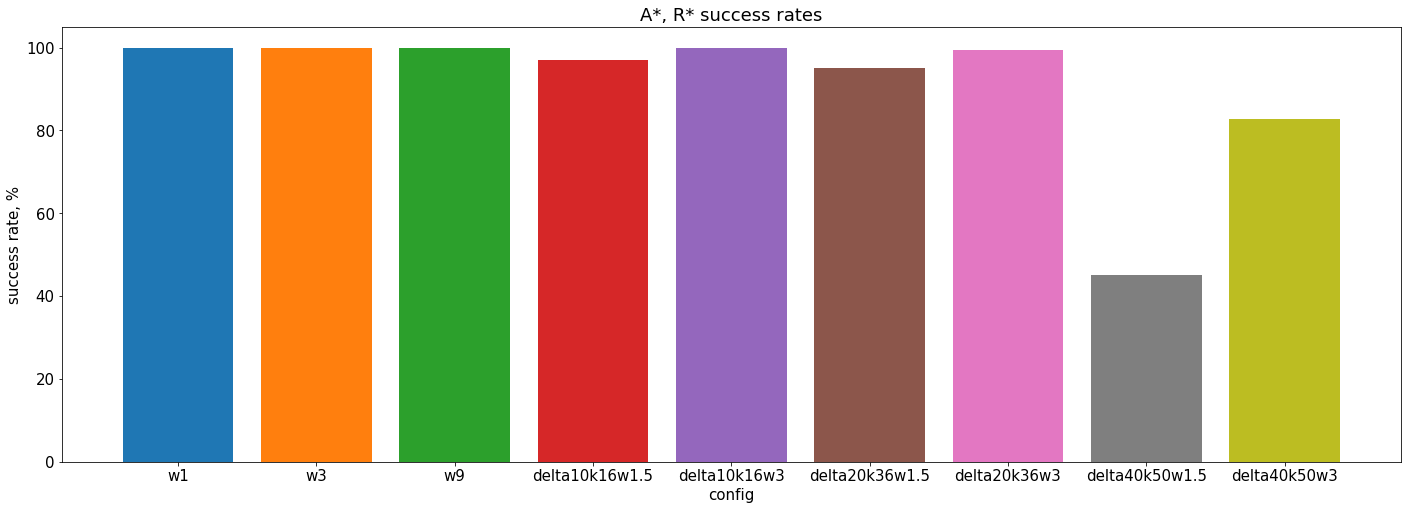

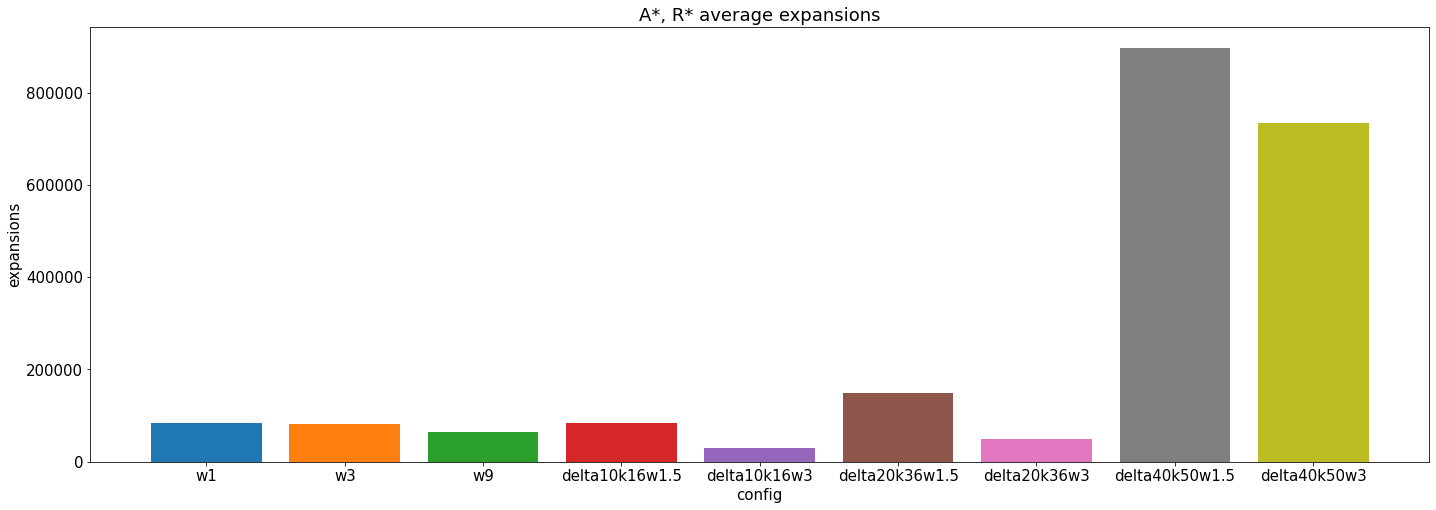

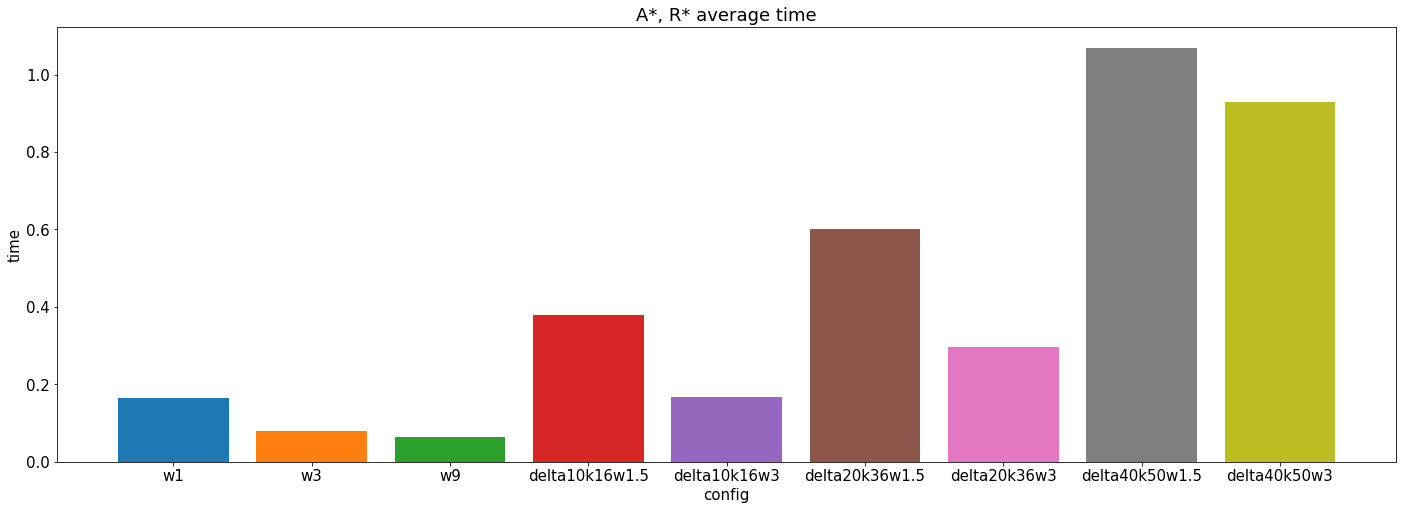

In [11]:
show_plots(results['cities-newyork'])

In [12]:
def extract_prefix(name2config, prefix):
    return {name : name2config[name] for name in name2config if name.startswith(prefix)}

In [13]:
def plot_metric_named(name2config, metric, prefix, names, xlabel):
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    order = sorted(extract_prefix(name2config, prefix).keys())
    for (config_name, bar_name) in zip(order, names):
        data = calc_average_metrics(name2config[config_name])
        plt.bar(bar_name, data[metric])

In [14]:
import numpy as np

def show_grouped_stats(name2config, metric, prefixes, names, labels, title):
    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    
    width = 1 / (len(names) + 1)
    for (i, (prefix, name)) in enumerate(zip(prefixes, names)):
        order = sorted(extract_prefix(name2config, prefix).keys())
        data = []
        for config_name in order:
            data.append(calc_average_metrics(name2config[config_name])[metric])
        ax.bar(x + (i - 1) * width, data, width=width, label=name)

    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

In [15]:
def show_mrastar_plots_with_names(map_results):
    res = map_results['mrastar']

    show_grouped_stats(
        res,
        'expansions',
        ["ncells_rr_", "ncells_ma_", "ncells_dts_"],
        ["Round-Robin", "Meta-A*", "DTS"],
        ["max=2", "max=4", "max=8", "max=16", "max=32", "max=64"],
        'MRA* average expansions by dicretization levels (w=3, suboptimality=5)'
    )
    
    show_grouped_stats(
        res,
        'time',
        ["ncells_rr_", "ncells_ma_", "ncells_dts_"],
        ["Round-Robin", "Meta-A*", "DTS"],
        ["max=2", "max=4", "max=8", "max=16", "max=32", "max=64"],
        'MRA* average time by dicretization levels (w=3, suboptimality=5)'
    )
    
    show_grouped_stats(
        res,
        'distance',
        ["ncells_rr_", "ncells_ma_", "ncells_dts_"],
        ["Round-Robin", "Meta-A*", "DTS"],
        ["max=2", "max=4", "max=8", "max=16", "max=32", "max=64"],
        'MRA* average distance by dicretization levels (w=3, suboptimality=5)'
    )

    hc_names = ["hc=3", "hc=5", "hc=10", "hc=20", "hc=30", "hc=100"]
    plt.title('MRA* with DTS average expansions by history coefficient (w=3, suboptimality=5, discretization=16)')
    plot_metric_named(res, 'expansions', "hc_", hc_names, 'DTS history coefficient')
    plt.show()

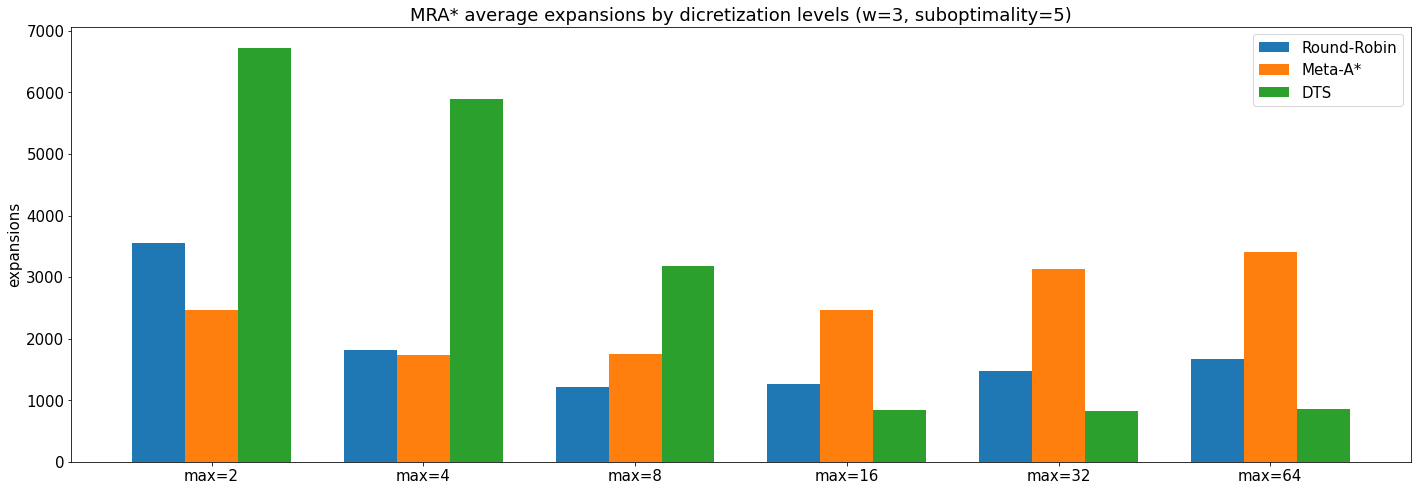

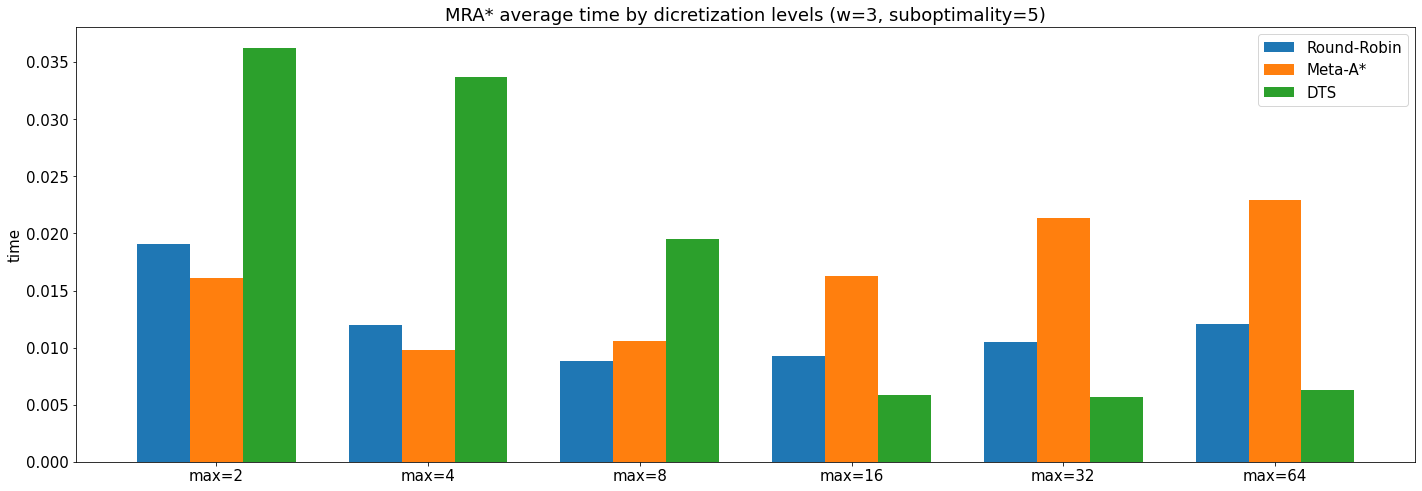

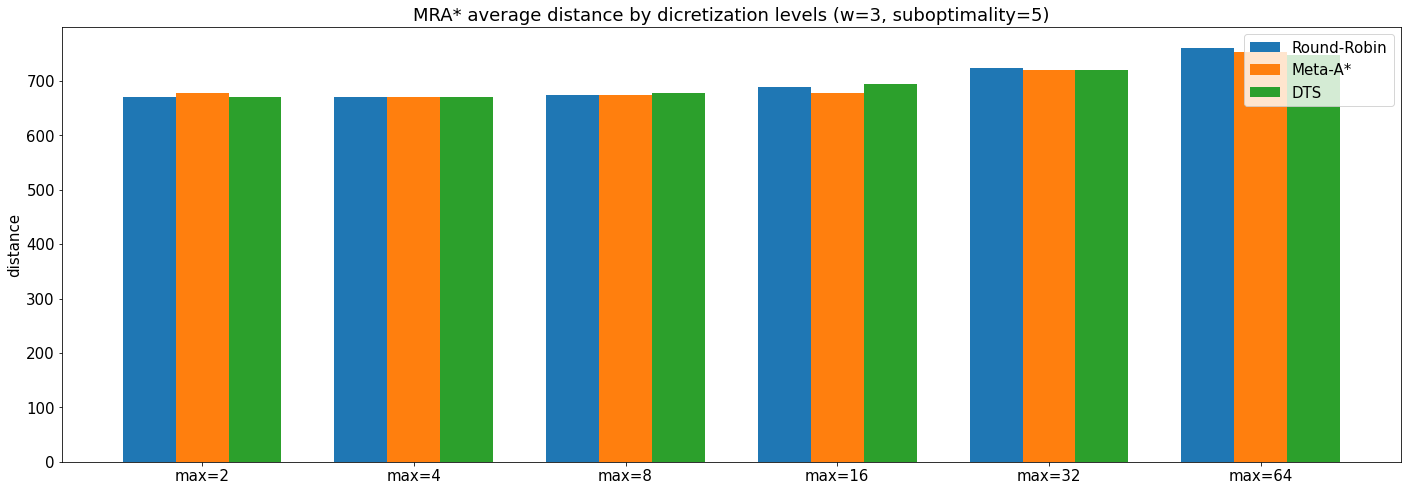

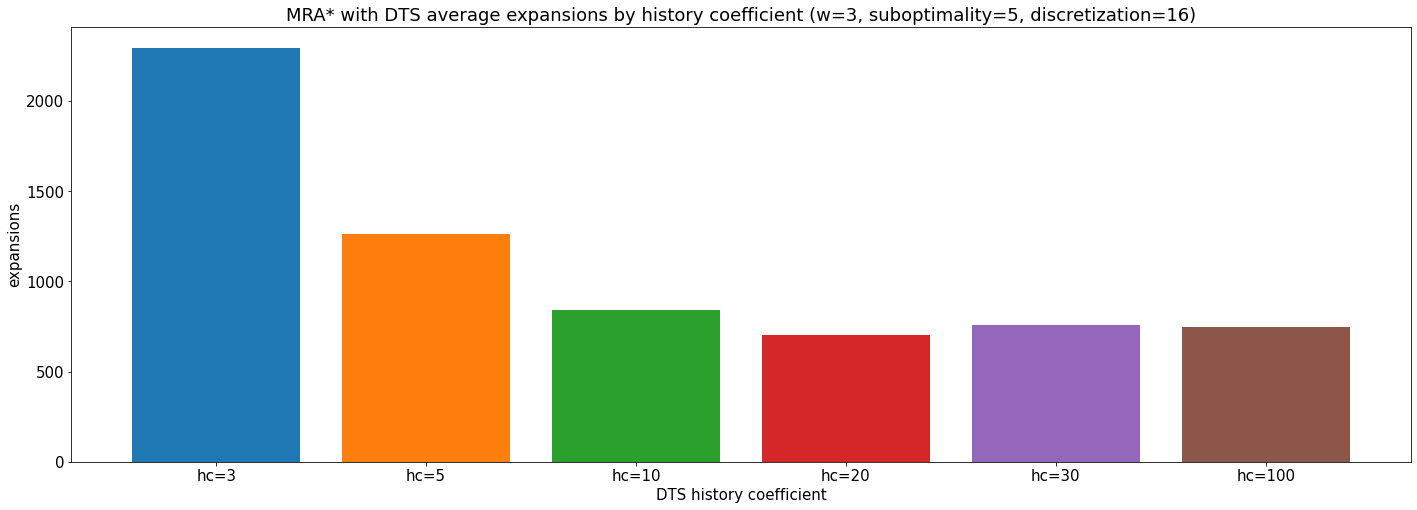

In [16]:
show_mrastar_plots_with_names(results['sc-broken-steppes'])

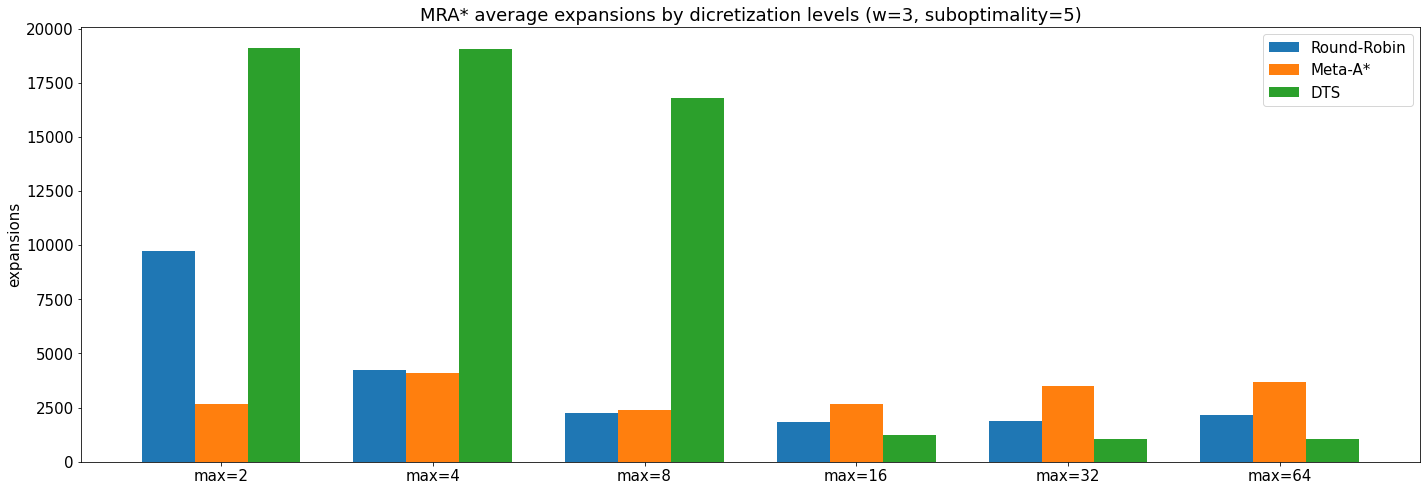

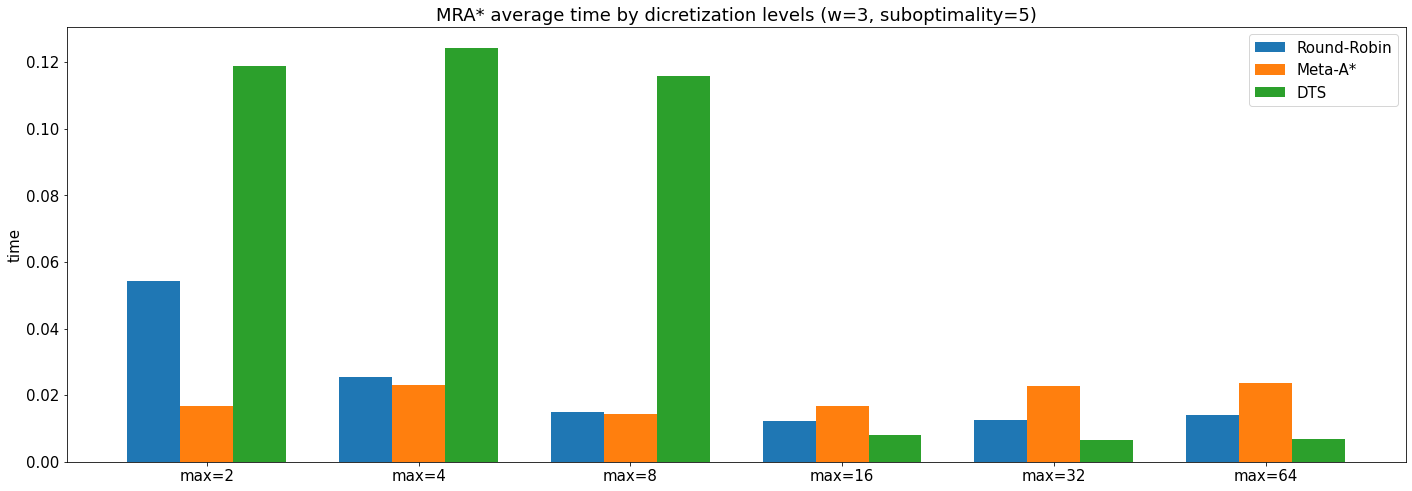

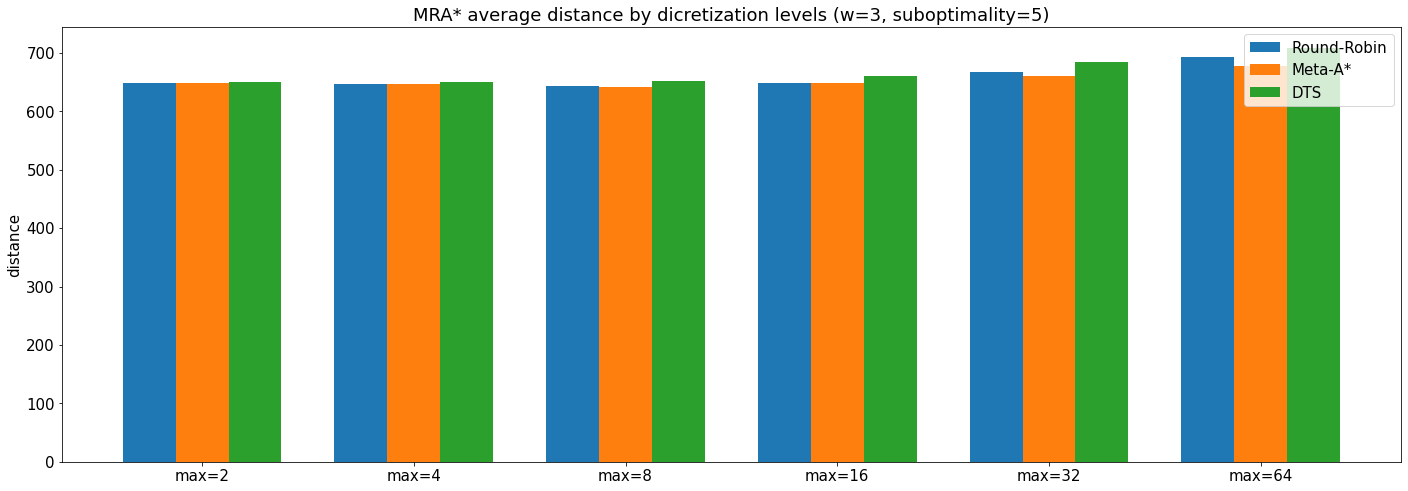

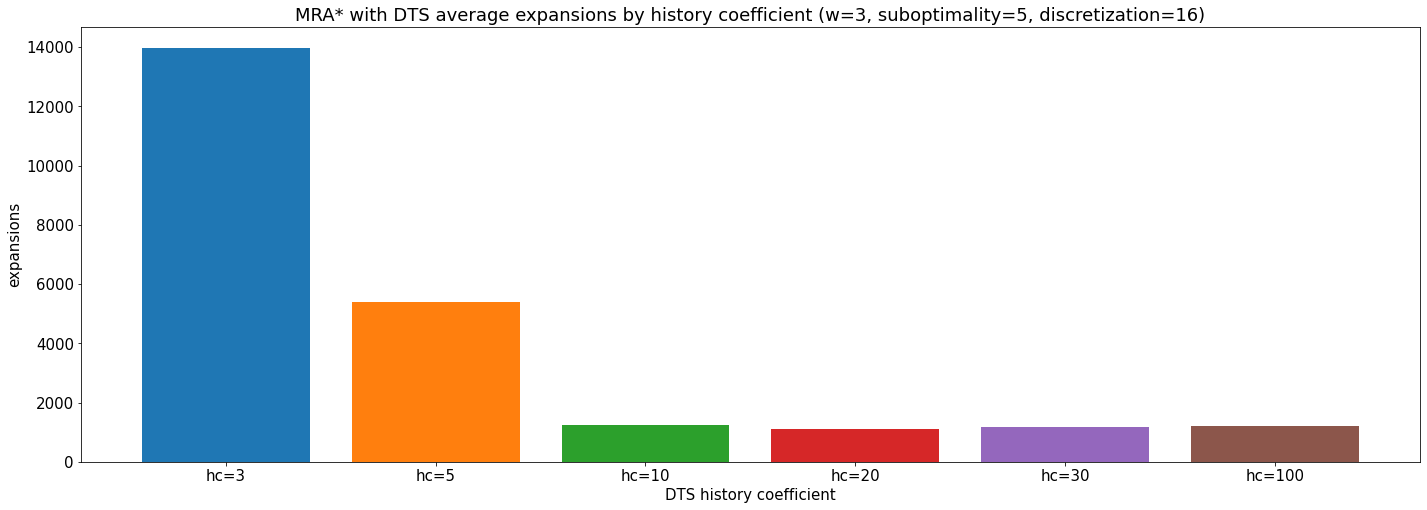

In [17]:
show_mrastar_plots_with_names(results['sc-wheel-of-war'])

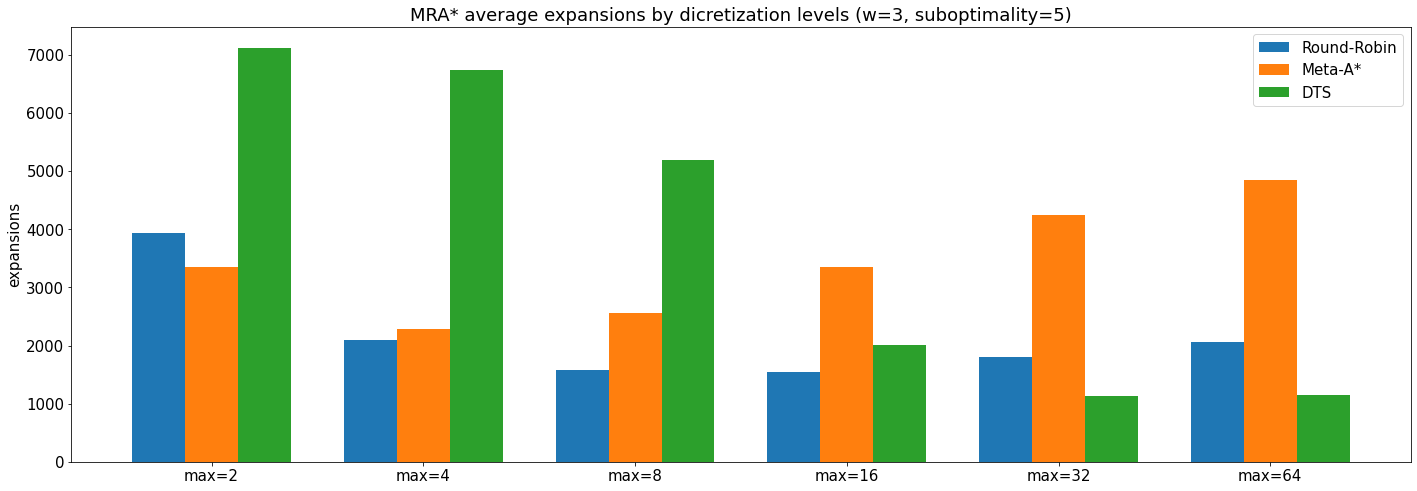

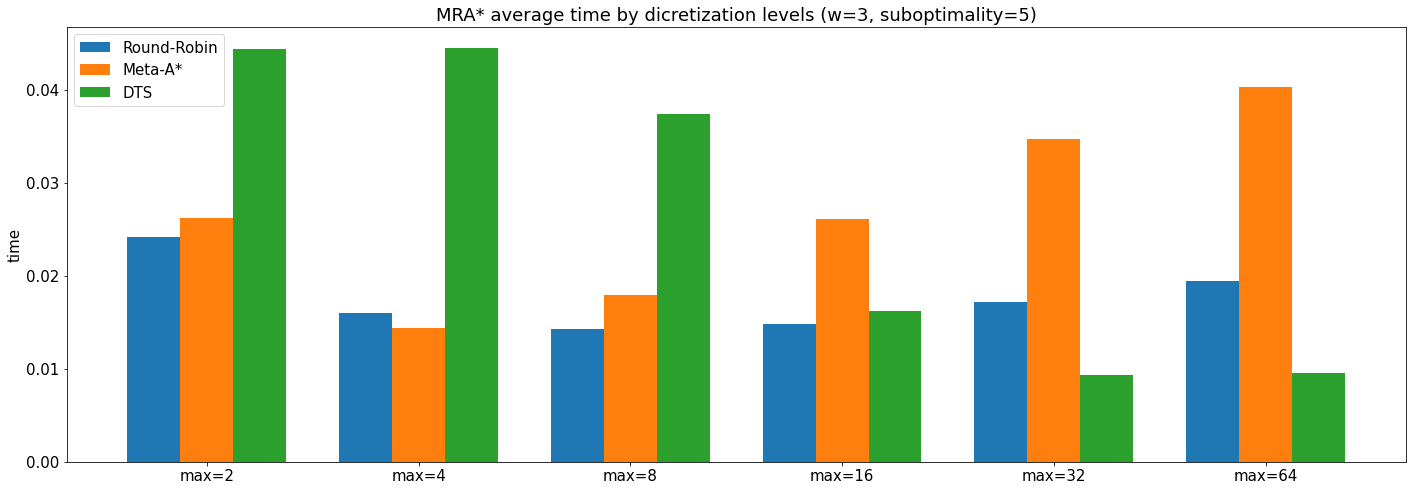

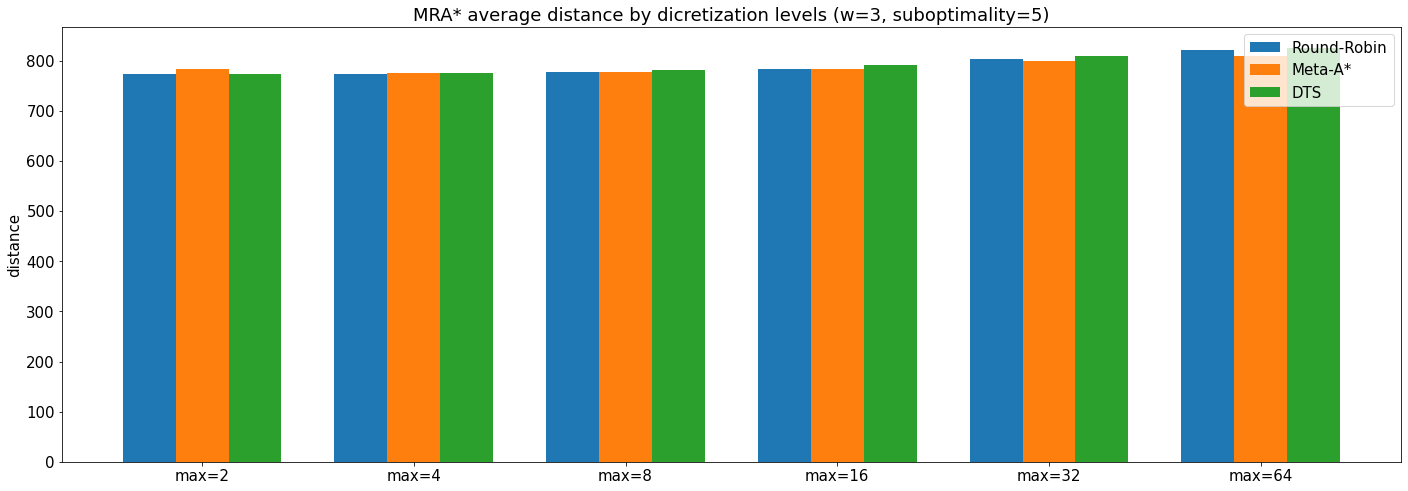

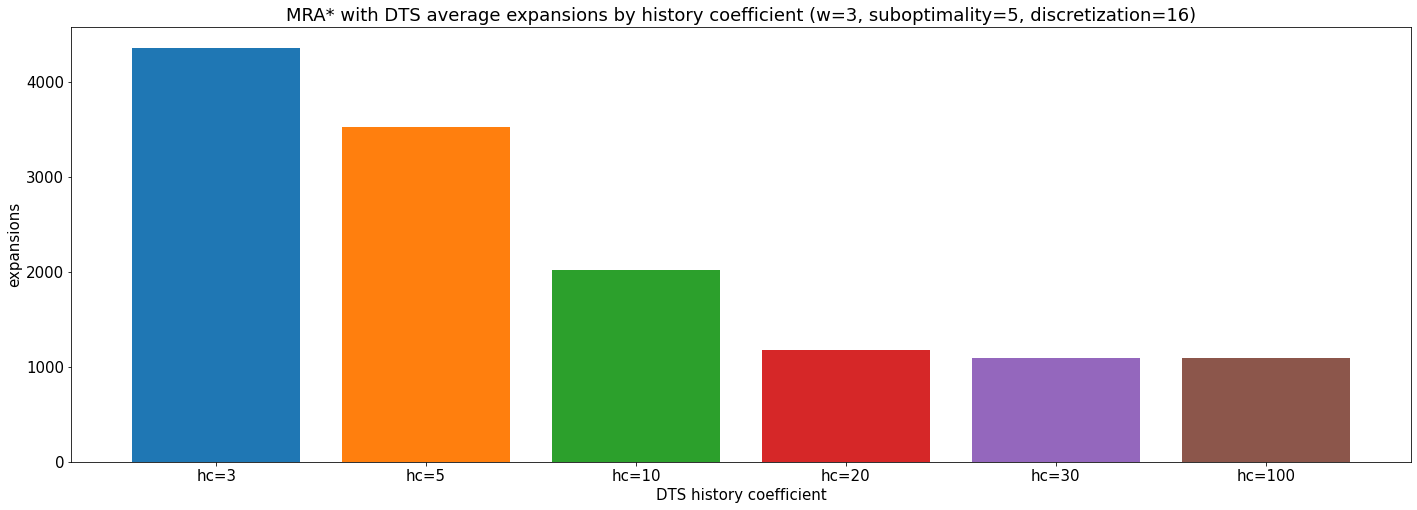

In [18]:
show_mrastar_plots_with_names(results['cities-milan'])

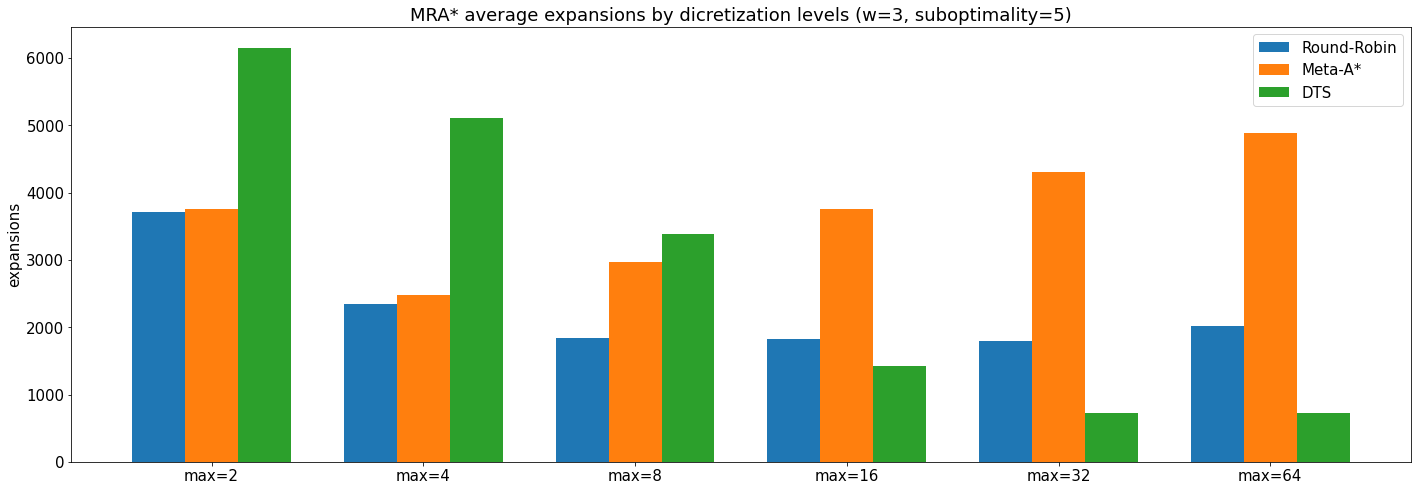

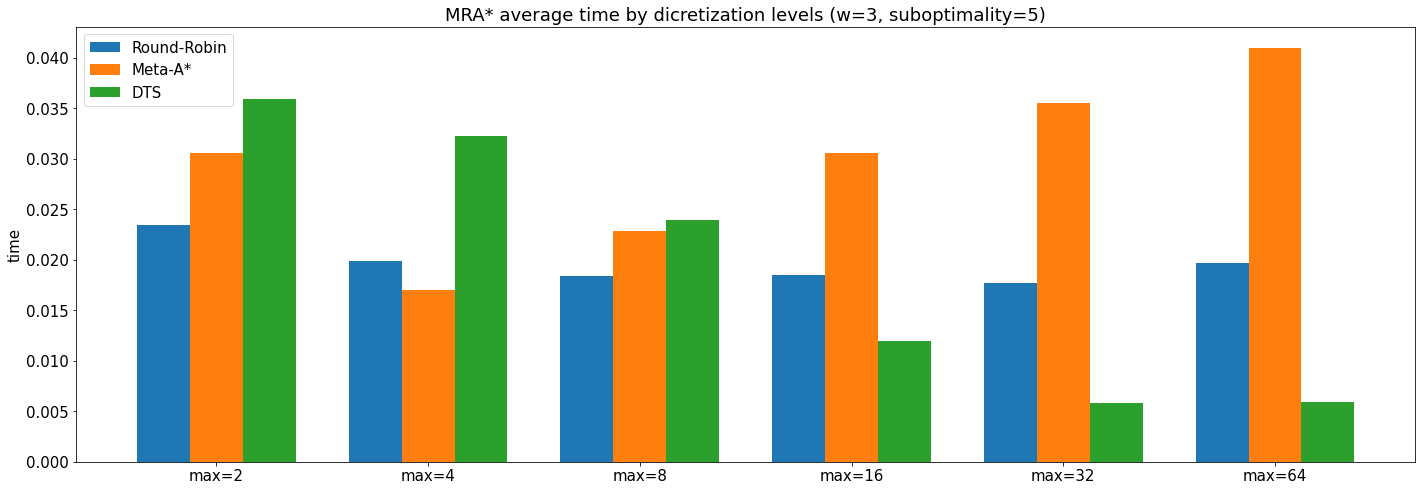

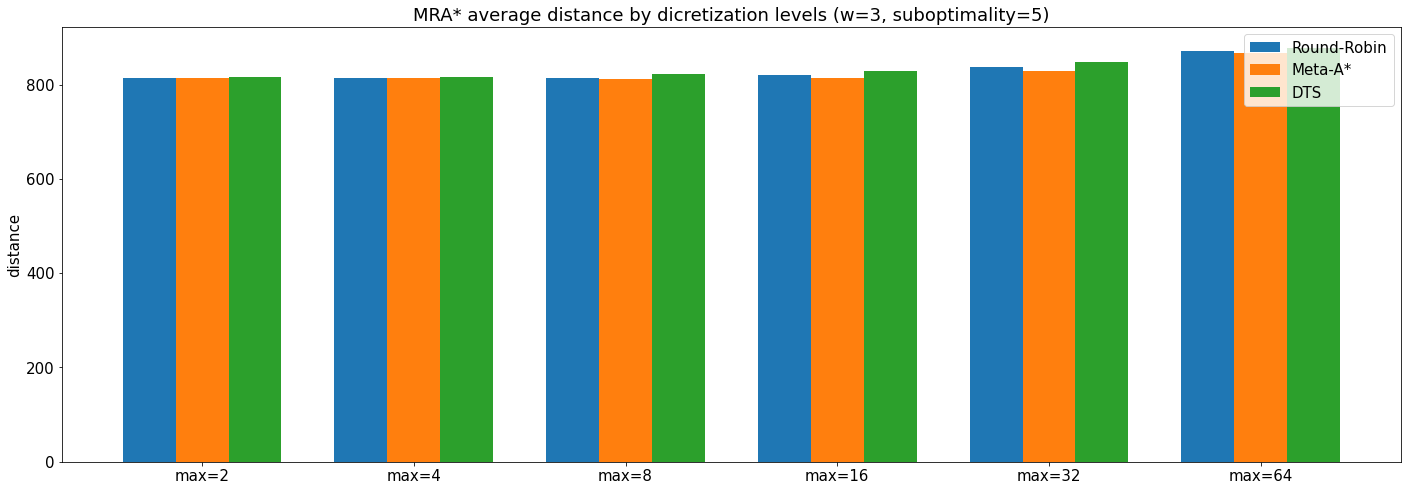

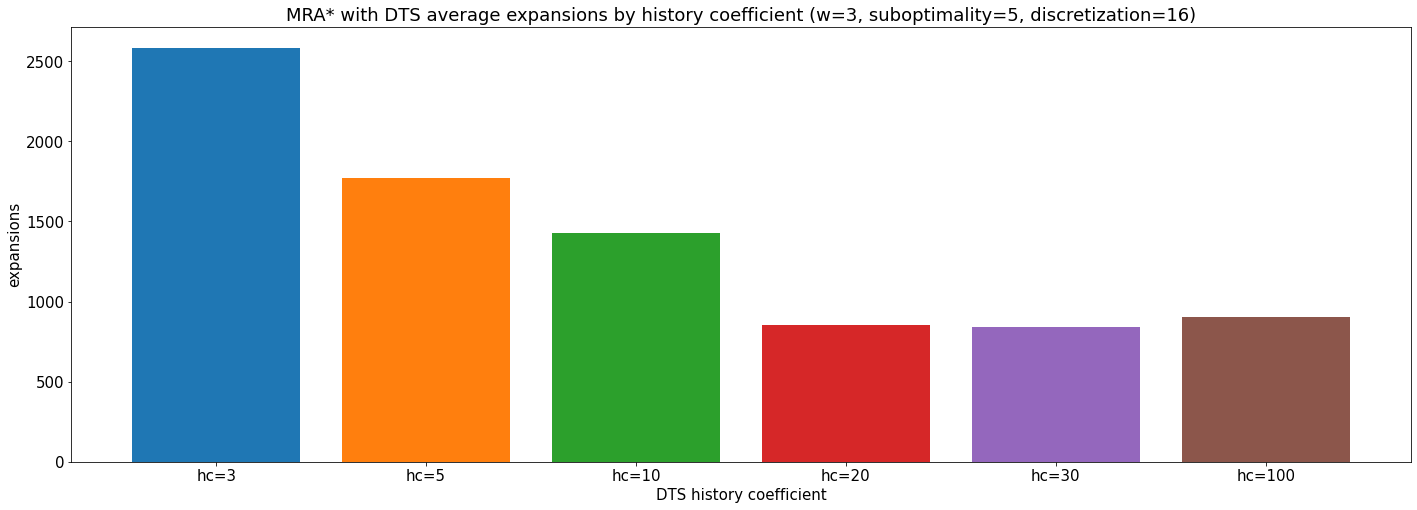

In [19]:
show_mrastar_plots_with_names(results['cities-newyork'])

In [20]:
def show_algorithms_grouped_stats(map_results, metric, algos, names, prefix, labels, title):
    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    
    width = 1 / (len(names) + 1)
    for (i, (algo, name)) in enumerate(zip(algos, names)):
        name2config = map_results[algo]
        data = []
        order = sorted(extract_prefix(name2config, prefix).keys())
        for config_name in order:
            data.append(calc_average_metrics(name2config[config_name])[metric])
        ax.bar(x + (i - 1) * width, data, width=width, label=name)

    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

In [21]:
def show_comparison(map_results):
    show_algorithms_grouped_stats(
        map_results,
        'expansions',
        ["astar", "rstar", "mrastar"],
        ["WA*", "R*", "MRA*"],
        "best_",
        ["w=3", "w=9"],
        'Average expansions of WA*, R* and MRA* with best parameters for map'
    )
    show_algorithms_grouped_stats(
        map_results,
        'time',
        ["astar", "rstar", "mrastar"],
        ["WA*", "R*", "MRA*"],
        "best_",
        ["w=3", "w=9"],
        'Average time of WA*, R* and MRA* with best parameters for map'
    )
    show_algorithms_grouped_stats(
        map_results,
        'distance',
        ["astar", "rstar", "mrastar"],
        ["WA*", "R*", "MRA*"],
        "best_",
        ["w=3", "w=9"],
        'Average distance of WA*, R* and MRA* with best parameters for map'
    )

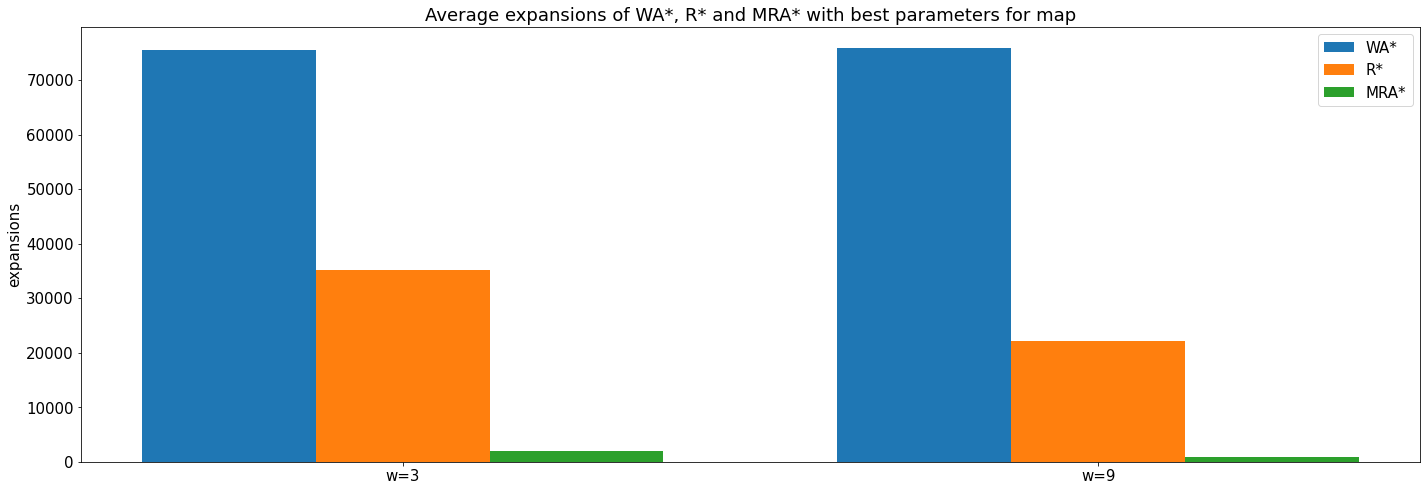

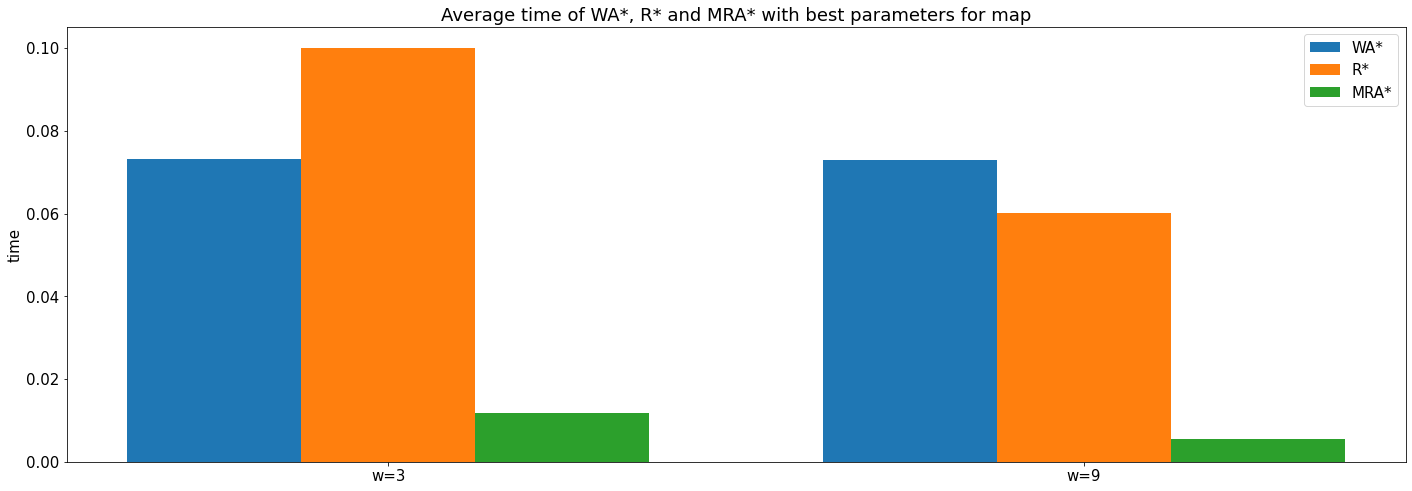

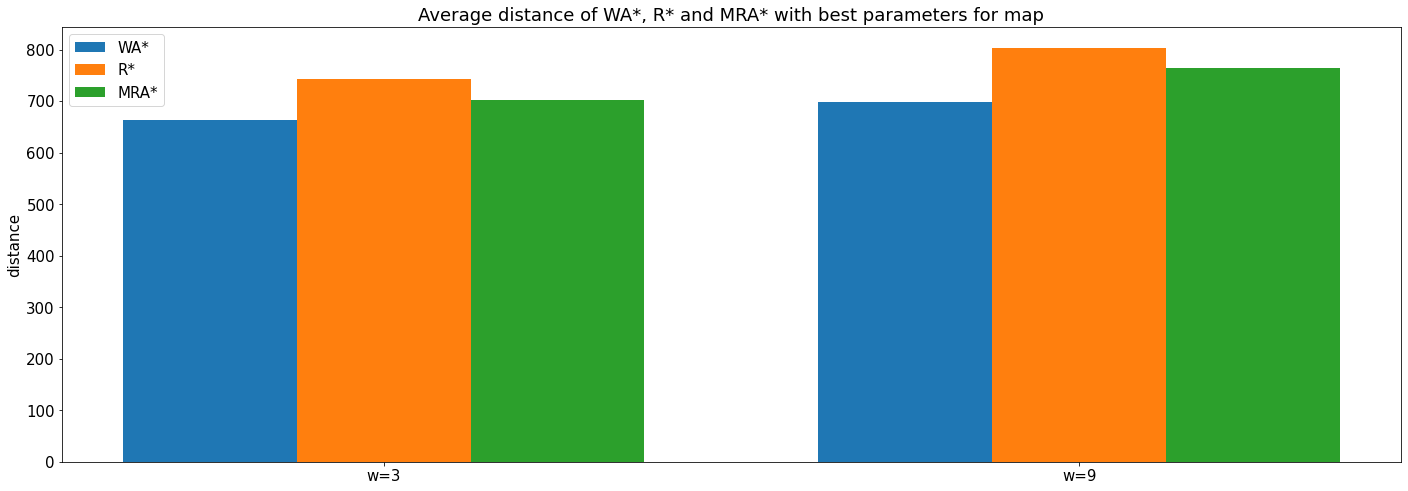

In [24]:
show_comparison(results['sc-broken-steppes'])

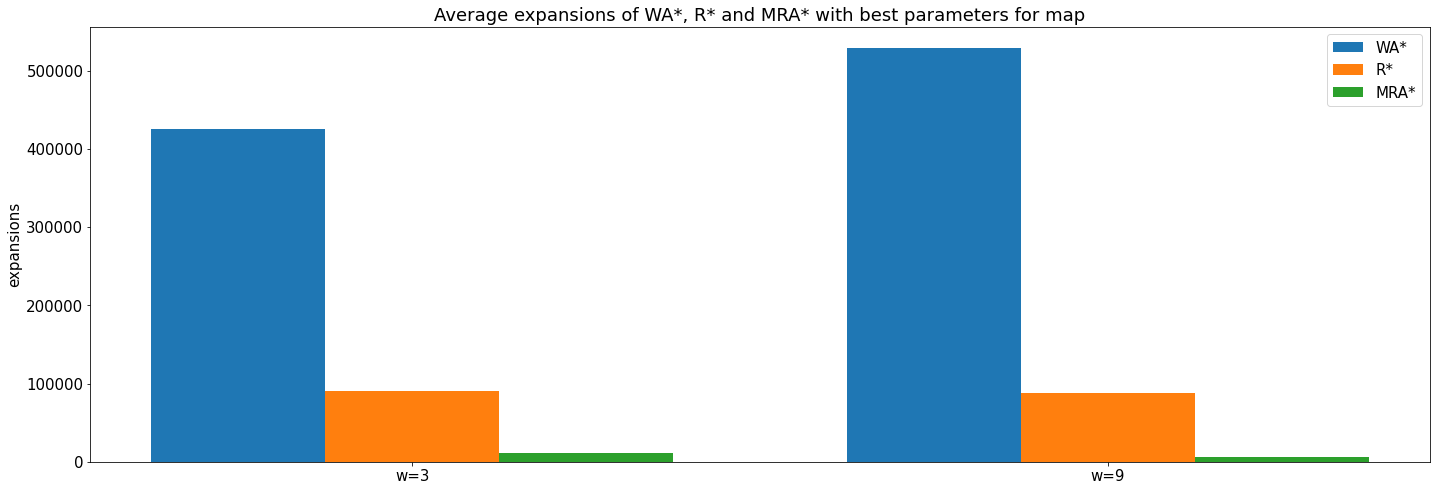

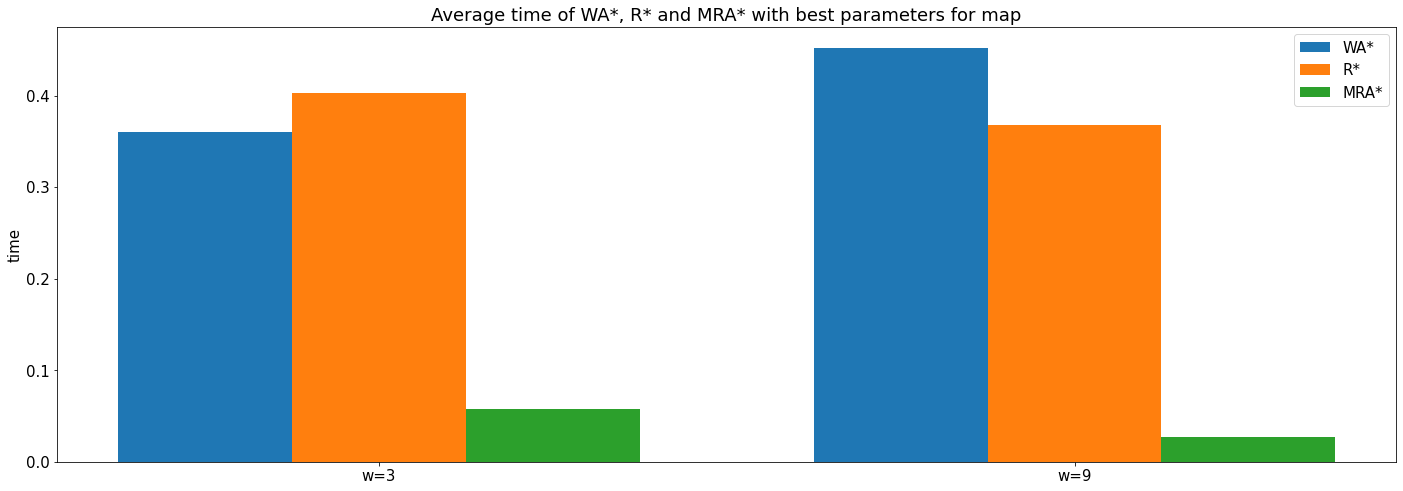

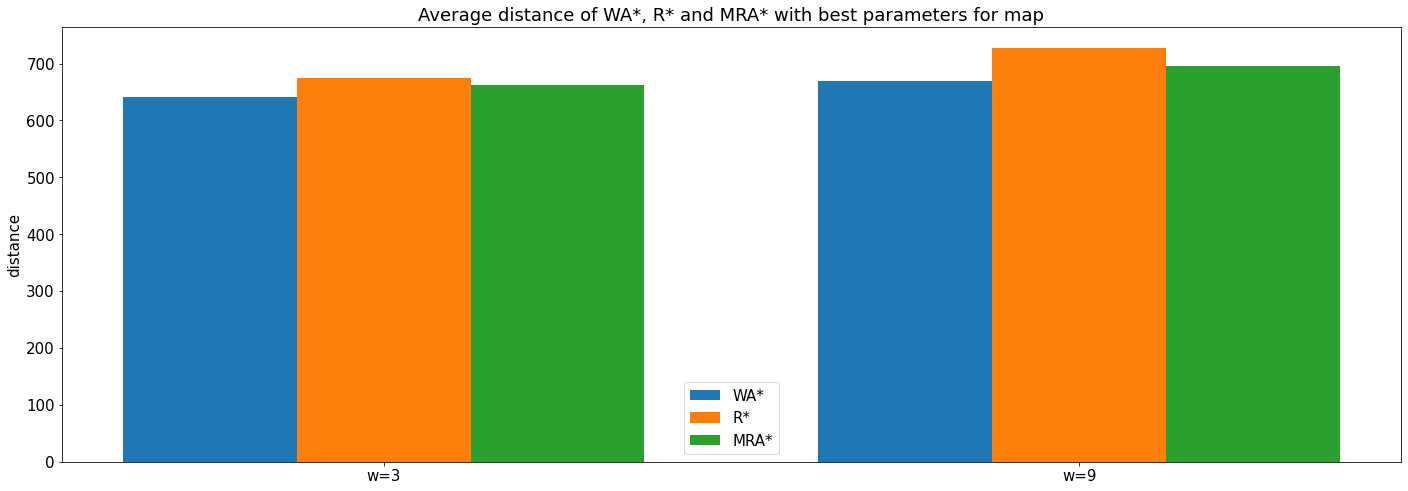

In [25]:
show_comparison(results['sc-wheel-of-war'])

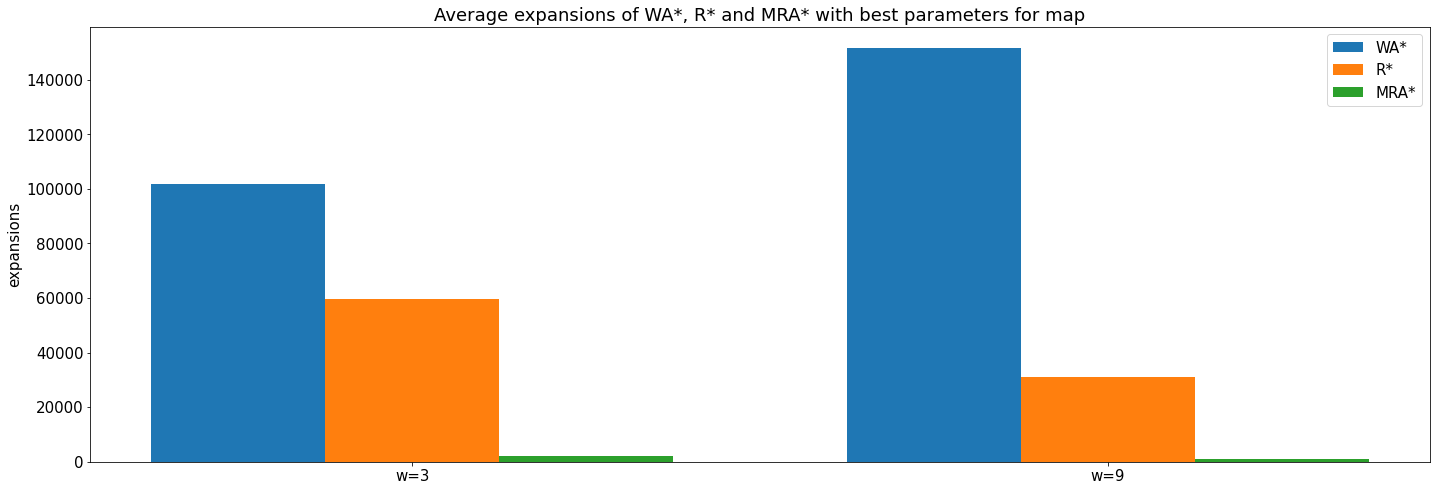

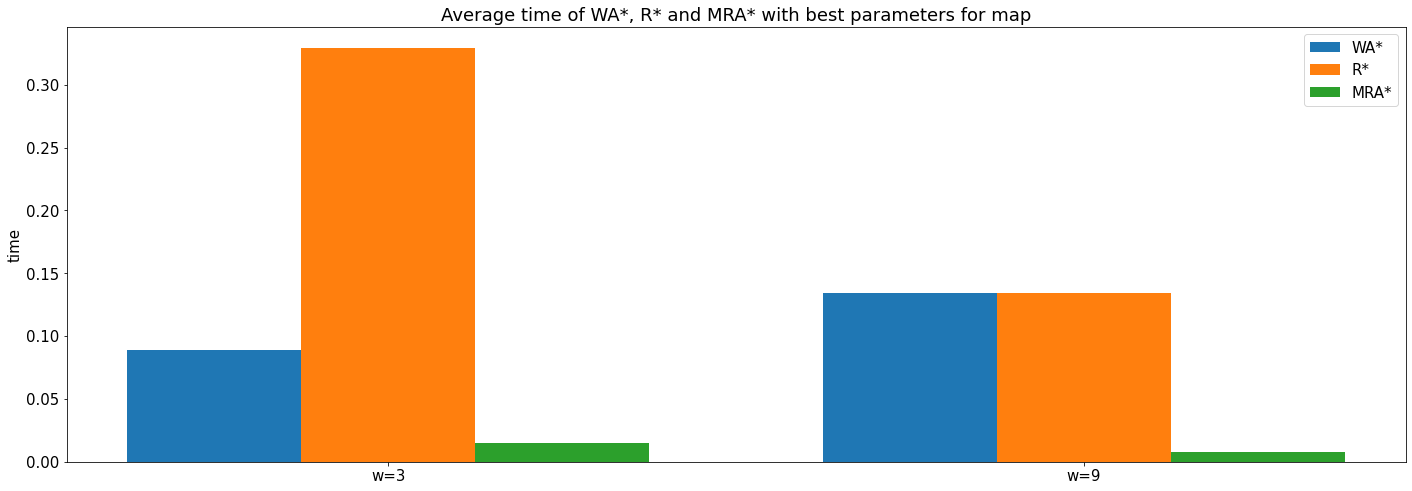

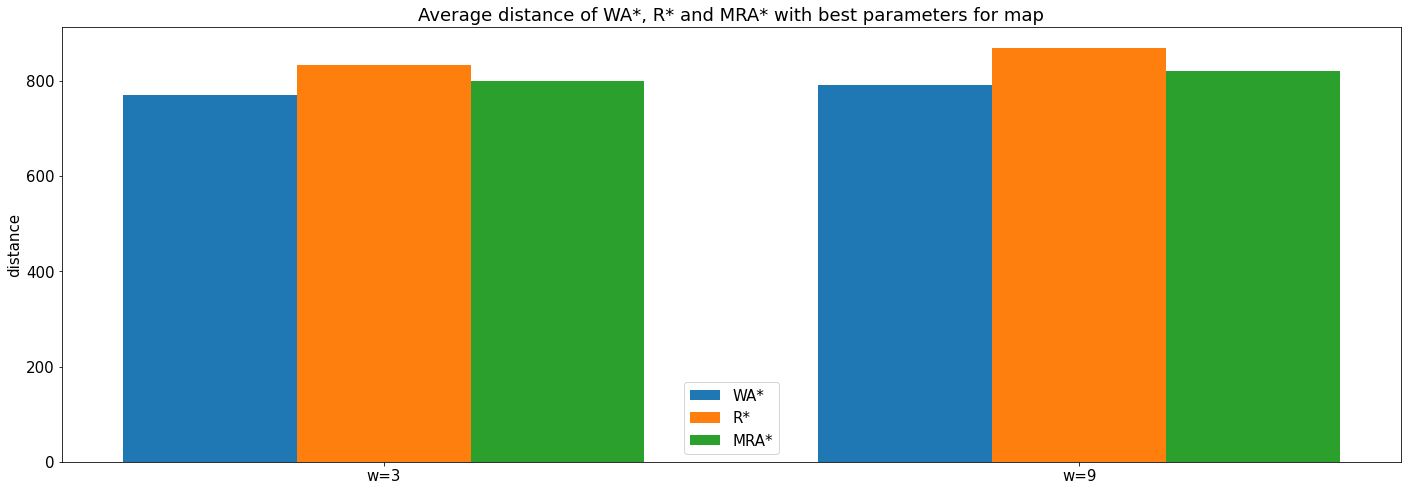

In [26]:
show_comparison(results['cities-milan'])

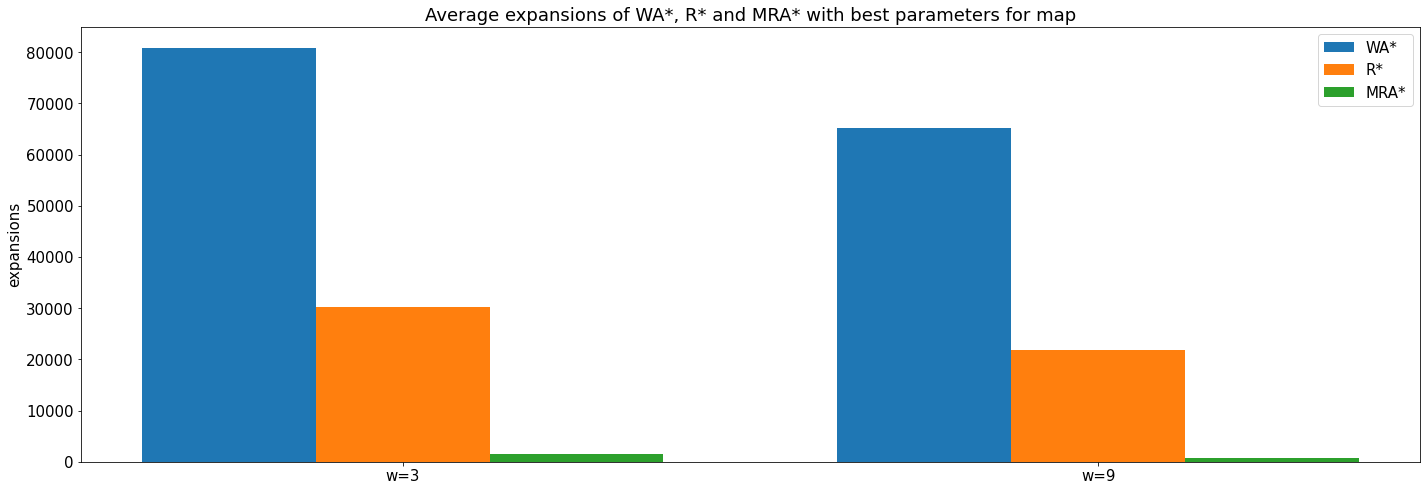

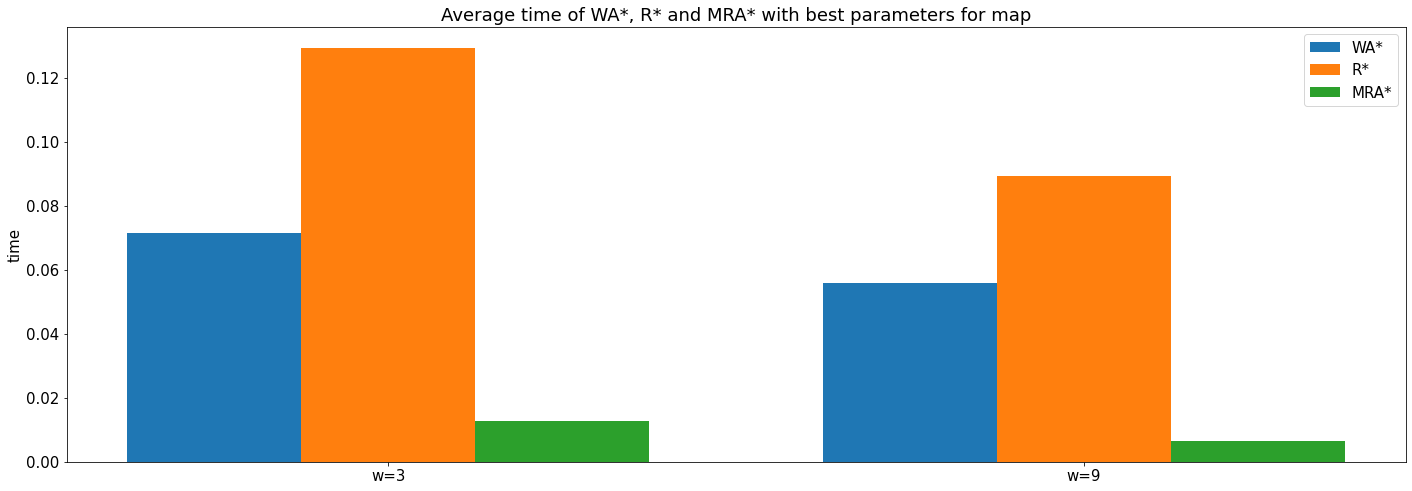

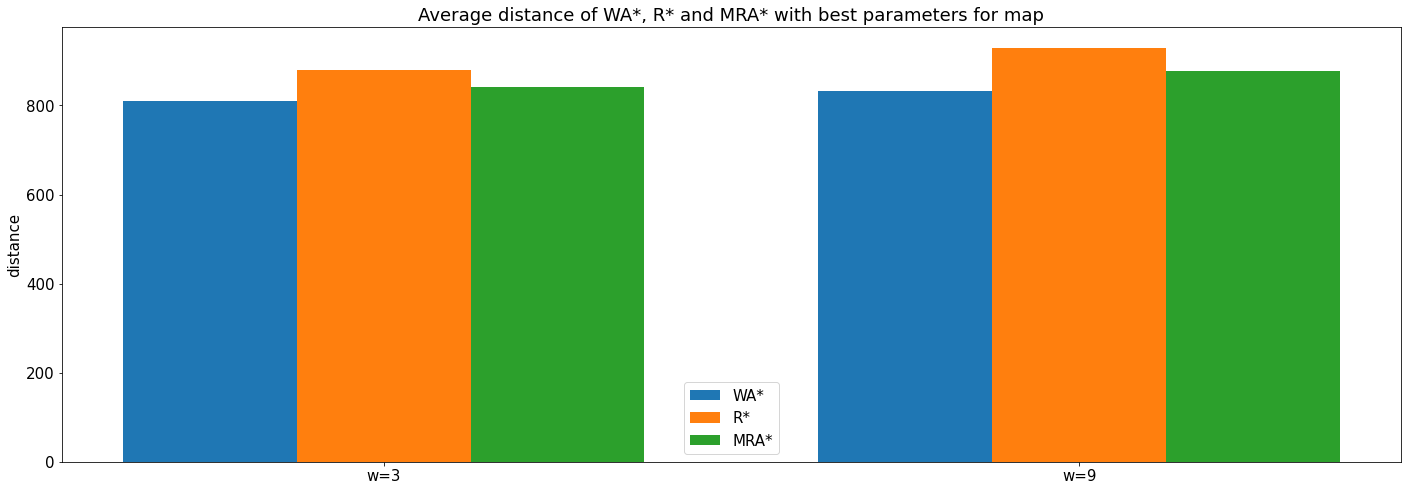

In [27]:
show_comparison(results['cities-newyork'])